### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.
* This homework uses TensorFlow v2.0: this is [how you install it](https://www.tensorflow.org/beta); and that's [how you use it](https://colab.research.google.com/drive/1YtfbZGgzKr7fpBTqkdEQtu4vUALoTv8A).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow
tensorflow.__version__

'2.0.0'

In [3]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
local_device_protos

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13338061669242778067, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4935529267
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11717284761715853438
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:1d:00.0, compute capability: 6.1"]

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [4]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

In [5]:
lines[:3]

[' Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question. Our single model outperforms the first place winner on the VQA 1.0 dataset, performs within margin to the current state-\n',
 ' Sequential Short-Text Classification with Recurrent and Convolutional   Neural Networks ; Recent approaches based on artificial neural networks (ANNs) have shown promising results for short-text classification. However, many short texts occur in sequences (e.g., sentences in a document or utterances in a dialog), and most existing ANN-based systems do not leverage the preceding short texts when classifying a subsequent one. In this work, we present a model based on recurre

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [6]:
# get all unique characters from lines (including capital letters and symbols)
tokens = list({ch for line in lines for ch in line})

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a TF-friendly integer vector.

In [7]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {token: i for i, token in enumerate(tokens)}

In [8]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [9]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype='int32'):
    """Casts a list of lines into tf-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [10]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))

len(dummy_lines[2])

[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


15

### Neural Language Model

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [11]:
import tensorflow as tf
keras, L = tf.keras, tf.keras.layers
assert tf.__version__.startswith('2'), "Current tf version: {}; required: 2.0.*".format(tf.__version__)

In [12]:
class FixedWindowLanguageModel(L.Layer):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        - If you're absolutely lost, here's a hint: use ZeroPadding1D and Conv1D from keras.layers
        You can stack several convolutions at once
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        kernel_size = 10
        strides = 1
        #YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        self.emb = L.Embedding(n_tokens, output_dim=emb_size)
        self.padd = L.ZeroPadding1D(padding= (strides * (kernel_size - 1), 0))
        self.conv = L.Conv1D(hid_size, kernel_size)
        self.dens = L.Dense(hid_size)
        self.drop = L.Dropout(0.1)
        self.final = L.Dense(n_tokens)
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        emb = self.emb(input_ix)
        padd = self.padd(emb)
        conv = self.conv(padd)

        drop = self.drop(conv)
        return self.final(drop)
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = tf.convert_to_tensor(to_matrix([prefix]), tf.int32)
        probs = tf.nn.softmax(self(prefix_ix)[0, -1]).numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [13]:
model = FixedWindowLanguageModel(n_tokens)

# note: tensorflow and keras layers create variables only after they're first applied (called)
dummy_input_ix = tf.constant(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

print('Weights:', tuple(w.name for w in model.trainable_variables))


Weights: ('embedding/embeddings:0', 'conv1d/kernel:0', 'conv1d/bias:0', 'dense_1/kernel:0', 'dense_1/bias:0')


In [14]:
dummy_logits.shape, (len(dummy_lines), max(map(len, dummy_lines)), n_tokens)

(TensorShape([3, 15, 136]), (3, 15, 136))

In [15]:
assert isinstance(dummy_logits, tf.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits)), "inf/nan encountered"
assert not np.allclose(dummy_logits.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [16]:
# test for lookahead
dummy_input_ix_2 = tf.constant(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert np.allclose(dummy_logits[:, :3] - dummy_logits_2[:, :3], 0), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

In [17]:
def compute_lengths(input_ix, eos_ix=token_to_id[EOS]):
    """ compute length of each line in input ix (incl. first EOS), int32 vector of shape [batch_size] """
    count_eos = tf.cumsum(tf.cast(tf.equal(input_ix, eos_ix), tf.int32), axis=1, exclusive=True)
    lengths = tf.reduce_sum(tf.cast(tf.equal(count_eos, 0), tf.int32), axis=1)
    return lengths

print('matrix:\n', dummy_input_ix.numpy())
print('lengths:', compute_lengths(dummy_input_ix).numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
lengths: [ 5  9 15]


We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [18]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    """
    input_ix = tf.convert_to_tensor(input_ix, dtype=tf.int32)
    

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]
    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you will likely need to use compute_lengths and/or tf.sequence_mask to get it right.
    
#     loss = tf.Variable(0.0, tf.float64)
#     tf.reduce_mean(tf.reduce_sum(, axis=1))
#     return -loss / D   
    mask = tf.sequence_mask(compute_lengths(input_ix), maxlen=logits.shape[1])
    flat_logits = tf.boolean_mask(logits, mask)
    flat_answers = tf.boolean_mask(reference_answers, mask)
    indexed_answers = tf.reshape(
        tf.stack([tf.reshape(tf.range(flat_answers.shape[0]), (-1, 1)), 
                  tf.reshape(flat_answers, shape=(-1, 1))], 
                 axis=1), 
        shape=(-1, 2)
    )
    probabilities = tf.gather_nd(tf.nn.softmax(flat_logits), indexed_answers)

    return tf.reduce_sum(-tf.math.log(probabilities) / input_ix.shape[0])

    

In [19]:
input_ix = tf.convert_to_tensor(to_matrix(dummy_lines, max_len=50), dtype=tf.float64)

In [20]:
tf.numpy_function(np.sum, [input_ix[0, :4]], tf.float64), input_ix[0, :4]

(<tf.Tensor: id=139, shape=(), dtype=float64, numpy=202.0>,
 <tf.Tensor: id=143, shape=(4,), dtype=float64, numpy=array([ 1., 66., 67., 68.])>)

In [21]:
loss_1 = compute_loss(model, to_matrix(dummy_lines, max_len=50))
loss_2 = compute_loss(model, to_matrix(dummy_lines, max_len=100))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert np.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use tf.sequence_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [22]:
from tqdm import tqdm, trange

In [23]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    for i in range(0, len(dev_lines), batch_size):
#         print(i)
        batch_ix = to_matrix(dev_lines[i: i + batch_size])
        dev_loss_num += compute_loss(model, batch_ix) * len(batch_ix)
        dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        if temperature == 0:
            next_token = tokens[np.argmax(probs)]
        else:
            probs = np.array([p ** (1. / temperature) for p in probs])
            probs /= sum(probs)
            next_token = np.random.choice(tokens, p=probs)
        
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [24]:
(len(lines ) * 0.75) / 256

120.1171875

### Training loop

Finally, let's train our model on minibatches of data

In [26]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
optimizer = keras.optimizers.Adam()

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridgingγ,H)/Su<v,yYs]oô°)Kó~õτ"ŁôO



In [33]:
from IPython.display import clear_output
from random import sample
from tqdm import trange


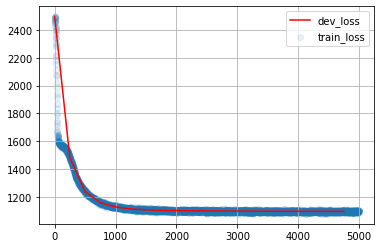

Generated examples (tau=0.5):
 Deapery th werksert th he geremsen for ang ing mented for the inactice propestin tor verelty and the
 Ansente andere-the deat on the vereat on the medel seationg th iont rofurmenting and me the s anclat
 Trals anc mate asing ared inge tore the lenere the repertint of the ceprone the the sed of amparithe
Scoring dev...
#4999 Dev loss: 1095.855


100%|██████████| 5000/5000 [11:36<00:00,  1.22s/it]


In [41]:

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    with tf.GradientTape() as tape:
        loss_i = compute_loss(model, batch)
    
    grads = tape.gradient(loss_i, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    train_history.append((i, loss_i.numpy()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [45]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.4))

Final dev loss: tf.Tensor(1095.8547, shape=(), dtype=float32)
 Ang inge the with sesture sse the ned by the seat of amize the problem and comention tha detren for 
 Modition ; In this probe mathod the the re meding ar an with s ane pared to senticl ore ures the of 
 Arnor and the the and compons ion ses anconser ang apestich ion long ing alation mate te rodetical s
 Destimale d and exteris the sed an dete dender cod and the serall ina probiction the caprexten to th
 Exprobent ons are problem of the serte serthe the and arale raperation for ancomentian intign inathe
 Ans and buthe s aplestion the reath ing ares enteration ly entemont of omporation thate s and us ora
 The formedend the sser ared the are con texe tod the rabel dy chmpreation the seruction thor pation 
 As of rimation les uration late tham ingerand cond andice formantich arale reat on the seation the r
 Asprobe provere tho s at one for are prevering ar works us intaris the sed ches ing an antiction tho
 Station the reatice

In [48]:
import pickle

In [49]:
with open('kernel10_drop_simple.pickle', 'wb') as f:
    pickle.dump(model.get_weights(), f)

In [46]:
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridging Monsewo co pherendy se whe ghy fo methical aci-baction ; rfor Gemectsiat rerustrater) lichou


### RNN Language Models

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [27]:
class RNNLanguageModel(L.Layer):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables/etc
        
        kernel_size = 5
        strides = 1
        self.emb = L.Embedding(n_tokens, emb_size)
        self.lstm = L.LSTM(hid_size, return_sequences=True)
        self.final = L.Dense(n_tokens)
        #END OF YOUR CODE
        
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        #YOUR CODE
        emb = self.emb(input_ix)
        lstm = self.lstm(emb)
#         dense = self.dense(lstm)
        return self.final(lstm)
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = tf.convert_to_tensor(to_matrix([prefix]), tf.int32)
        probs = tf.nn.softmax(self(prefix_ix)[0, -1]).numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [28]:
dummy_logits.shape, len(dummy_lines), max(map(len, dummy_lines)), n_tokens

(TensorShape([3, 15, 136]), 3, 15, 136)

In [29]:
model = RNNLanguageModel()

# note: tensorflow and keras layers create variables only after they're first applied (called)
dummy_input_ix = tf.constant(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, tf.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits)), "inf/nan encountered"
assert not np.allclose(dummy_logits.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(w.name for w in model.trainable_variables))

Weights: ('embedding_1/embeddings:0', 'lstm/kernel:0', 'lstm/recurrent_kernel:0', 'lstm/bias:0', 'dense_2/kernel:0', 'dense_2/bias:0')


In [30]:
# test for lookahead
dummy_input_ix_2 = tf.constant(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert np.allclose(dummy_logits[:, :3] - dummy_logits_2[:, :3], 0), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to prepare tensorflow graph that would minimize the same loss function. If you encounter large loss fluctuations during training, please add gradient clipping using urls above.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [31]:
batch_size = 256         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []
optimizer = keras.optimizers.Adam()

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridging[Q_)0]ρ@(äUG3[ρê1qX|aí7νc?X:4ω*hLi



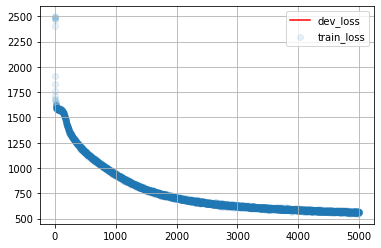

Generated examples (tau=0.5):
 Reduction System for Meaning Data for Discriminative Multi-Scale Like Sparse Structure ; In this pap
 A Network in Structured Approach for Structure Contains ; In this paper, we propose a new approach t
 Data Structure Text Selection of Multi-Scale Detection ; We propose a problem of infrarators is a sp


100%|██████████| 5000/5000 [20:50<00:00,  1.24it/s]


In [34]:
for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    with tf.GradientTape() as tape:
        loss_i = compute_loss(model, batch)
        
    grads = tape.gradient(loss_i, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    train_history.append((i, loss_i.numpy()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for i in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [50]:
# assert np.mean(train_history[:10]) > np.mean(train_history[-10:]), "The model didn't converge."
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: tf.Tensor(2498.1018, shape=(), dtype=float32)
 A Structure Learning and Region Model with Model   Scale Similar Profiling ; In this paper, we prese
 A Classification of Computer Sparse Discovery for Automatic Algorithm ; We study the problem of mach
 A Statistical State-Sparse Learning ; The focus of Multi-Case On the article and the original transl
 Deep Neural Network for Deep Convolutional Neural Networks ; The addressmannous problems such as a s
 A Provided Detection for Distributional Structure Denomal Problems ; This paper presents a novel app
 A Set of Distributed Approach for Convolutional Neural Networks ; The presence of the computational 
 Evaluation Problems with Logical Real-widely used a frequency function ; The underlying the non-mode
 Model Convolutional Neural Networks ; We propose a new recognition of the problem and contain the ax
 A Deep Neural Networks of Recent Approach to Detect Bandits ; Recently assumption to a sensor of the
 A Set of Deep Learn

In [49]:
# np.mean(train_history[-20:]), np.mean(train_history[-10:]), len(train_history)
np.mean(train_history[:10], axis=0)[1], np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
np.mean(train_history[:10], axis=0), np.mean(train_history[-10:], axis=0)

(array([   4.5       , 2204.23094482]), array([4994.5       ,  561.14408569]))

In [40]:
import pickle
with open('lstm_simple.pickle', 'wb') as f:
    pickle.dump(model.get_weights(), f)

### Bonus quest: Ultimate Language Model

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;



_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_